In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm

In [13]:
data_path = '../data'
df = pd.read_csv(f'{data_path}/all_subjects_with_regime.csv', index_col=0)

In [14]:
def create_features(df, features):
    cols = list(df.columns) + features
    df['t-1_action'] = df.groupby('subject')['action'].shift(1)
    df['t-2_action'] = df.groupby('subject')['action'].shift(2)
    df['t-1_correct'] = df.groupby('subject')['correct'].shift(1)
    df['t-2_correct'] = df.groupby('subject')['correct'].shift(2)
    df['t-1_reward'] = df.groupby('subject')['reward'].shift(1)
    df['t-2_reward'] = df.groupby('subject')['reward'].shift(2)
    df['t-1_action_correct_interaction'] = df['t-1_action'] * df['t-1_correct']
    df['t-2_action_correct_interaction'] = df['t-2_action'] * df['t-2_correct']
    df['t-1_action_reward_interaction'] = df['t-1_action'] * df['t-1_reward']
    df['t-2_action_reward_interaction'] = df['t-2_action'] * df['t-2_reward']
    return df[cols]

In [32]:
def split_train_test_same_regime(df):
    df_train = df[df['obs_num'] <= 600]
    df_test = df[(df['obs_num'] > 600) & (df['obs_num'] <= 800)]
    return df_train, df_test

def split_train_test_change_regime(df):
    df_train = df[df['obs_num'] <= 800]
    df_test = df[df['obs_num'] > 800]
    return df_train, df_test

def split_train_test_only_regular(df):
    df_train = df[(df['obs_num'] < 600) & (df['regime'] == 0)]
    df_test = df[(df['obs_num'] >= 600) & (df['obs_num'] < 800) & (df['regime'] == 0)]
    return df_train, df_test

def split_train_test_only_irregular(df):
    df_train = df[(df['obs_num'] < 600) & (df['regime'] == 1)]
    df_test = df[(df['obs_num'] >= 600) & (df['obs_num'] < 800) & (df['regime'] == 1)]
    return df_train, df_test

In [16]:
def prepare_X_y(df, features, target):
    df_no_na = df.dropna(subset=features+[target])
    X = sm.add_constant(np.array(df_no_na[features]))
    y = np.array(df_no_na[target])
    return X, y
    

In [29]:
def logistic_model_factory(X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    with pm.Model() as model:
        # Define priors
        intercept = pm.Normal('Intercept', 0, sd=10)
        coefs = {f'{feature}_coef': pm.Normal(feature, 0, sd=10) for feature in features}
        likelihood = pm.math.sigmoid(intercept+coefs['t-1_action_coef']*X[:,1]+coefs['t-2_action_coef']*X[:,2]+
                                     coefs['t-1_action_reward_interaction_coef']*X[:,3])
        observation = pm.Bernoulli('obs', likelihood, observed= y)
    return model

def fit_model(model_factory, X, y):
    with model_factory(X_train, y_train) as model: 
        trace = pm.sample(1000)
    return trace

def create_predictions(model_factory, trace, X, y):
    with model_factory(X_test, y_test) as model: 
        ppc = pm.sample_posterior_predictive(trace)
    return ppc

def evaluate_predictions(predictions, y):
    predictions = pd.DataFrame({'prob_action_1': np.mean(predictions['obs'], axis=0), 'action': y})
    predictions['predicted_action'] = (predictions['prob_action_1'] > 0.5).astype(int)
    predictions['previous_action'] = predictions['action'].shift(1)
    predictions['correct'] = predictions['predicted_action'] == predictions['action']
    accuracy = predictions['correct'].mean()
    return predictions, accuracy

In [18]:
features = ['t-1_action', 't-2_action', 't-1_action_reward_interaction']
target = 'action'
df = create_features(df, features)

In [41]:
# Same regime train and test:
df_train, df_test = split_train_test_same_regime(df)
X_train, y_train = prepare_X_y(df_train, features, target)
X_test, y_test = prepare_X_y(df_test, features, target)

trace = fit_model(logistic_model_factory, X_train, y_train)
predicted_values = create_predictions(logistic_model_factory, trace, X_test, y_test)
predictions, accuracy = evaluate_predictions(predicted_values, y_test)
print(accuracy)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t-1_action_reward_interaction, t-2_action, t-1_action, Intercept]
100%|██████████| 4000/4000 [00:06<00:00, 664.07it/s]


0.7519648872103705


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33ecd8a0f0>,
      dtype=object)

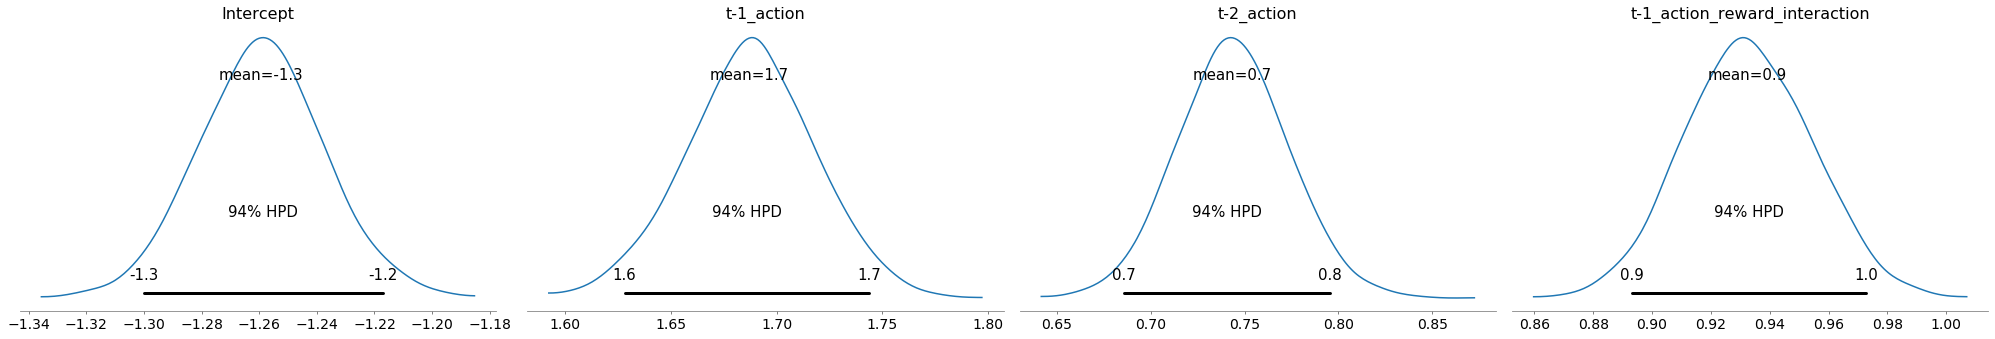

In [42]:
pm.plot_posterior(trace)

In [43]:
# Change regime train and test:
df_train, df_test = split_train_test_change_regime(df)
X_train, y_train = prepare_X_y(df_train, features, target)
X_test, y_test = prepare_X_y(df_test, features, target)

trace = fit_model(logistic_model_factory, X_train, y_train)
predicted_values = create_predictions(logistic_model_factory, trace, X_test, y_test)
predictions, accuracy = evaluate_predictions(predicted_values, y_test)
print(accuracy)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t-1_action_reward_interaction, t-2_action, t-1_action, Intercept]
100%|██████████| 4000/4000 [00:05<00:00, 707.76it/s]


0.7553332652852914


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33e4f4e240>,
      dtype=object)

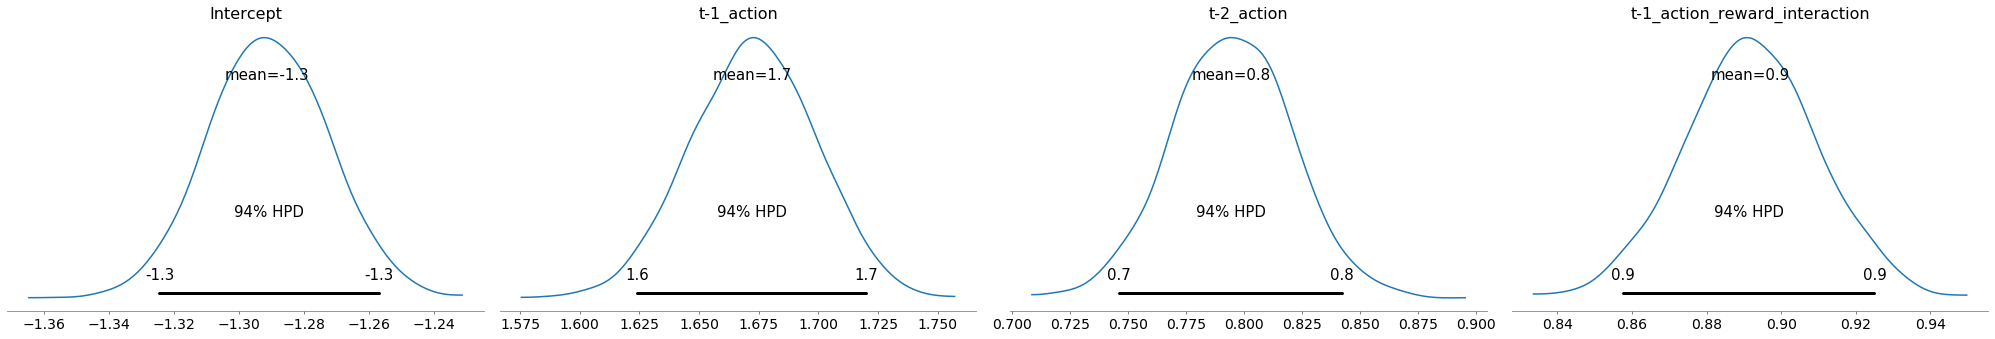

In [44]:
pm.plot_posterior(trace)

In [45]:
# Only regular
df_train, df_test = split_train_test_only_regular(df)
X_train, y_train = prepare_X_y(df_train, features, target)
X_test, y_test = prepare_X_y(df_test, features, target)

trace = fit_model(logistic_model_factory, X_train, y_train)
predicted_values = create_predictions(logistic_model_factory, trace, X_test, y_test)
predictions, accuracy = evaluate_predictions(predicted_values, y_test)
print(accuracy)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t-1_action_reward_interaction, t-2_action, t-1_action, Intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:20<00:00, 289.44draws/s]
The acceptance probability does not match the target. It is 0.8869300672025157, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 4000/4000 [00:04<00:00, 875.82it/s]


0.7638888888888888


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33ece949b0>,
      dtype=object)

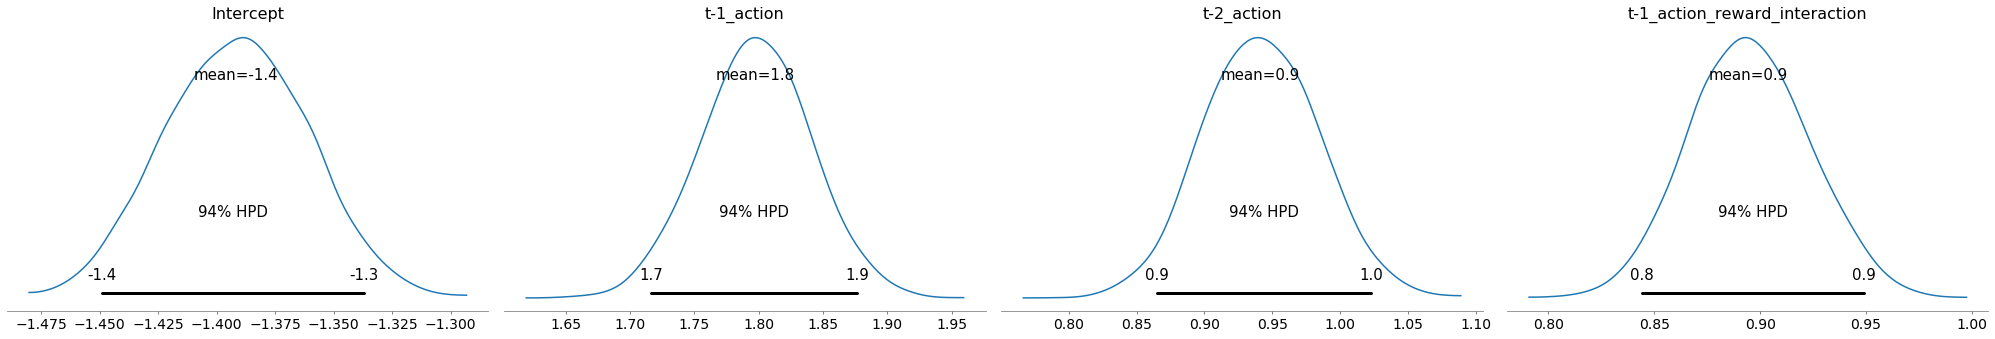

In [46]:
pm.plot_posterior(trace)

In [47]:
# Only irregular
df_train, df_test = split_train_test_only_irregular(df)
X_train, y_train = prepare_X_y(df_train, features, target)
X_test, y_test = prepare_X_y(df_test, features, target)

trace = fit_model(logistic_model_factory, X_train, y_train)
predicted_values = create_predictions(logistic_model_factory, trace, X_test, y_test)
predictions, accuracy = evaluate_predictions(predicted_values, y_test)
print(accuracy)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t-1_action_reward_interaction, t-2_action, t-1_action, Intercept]
100%|██████████| 4000/4000 [00:04<00:00, 992.79it/s] 


0.7273140777803048


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33ec8baa90>,
      dtype=object)

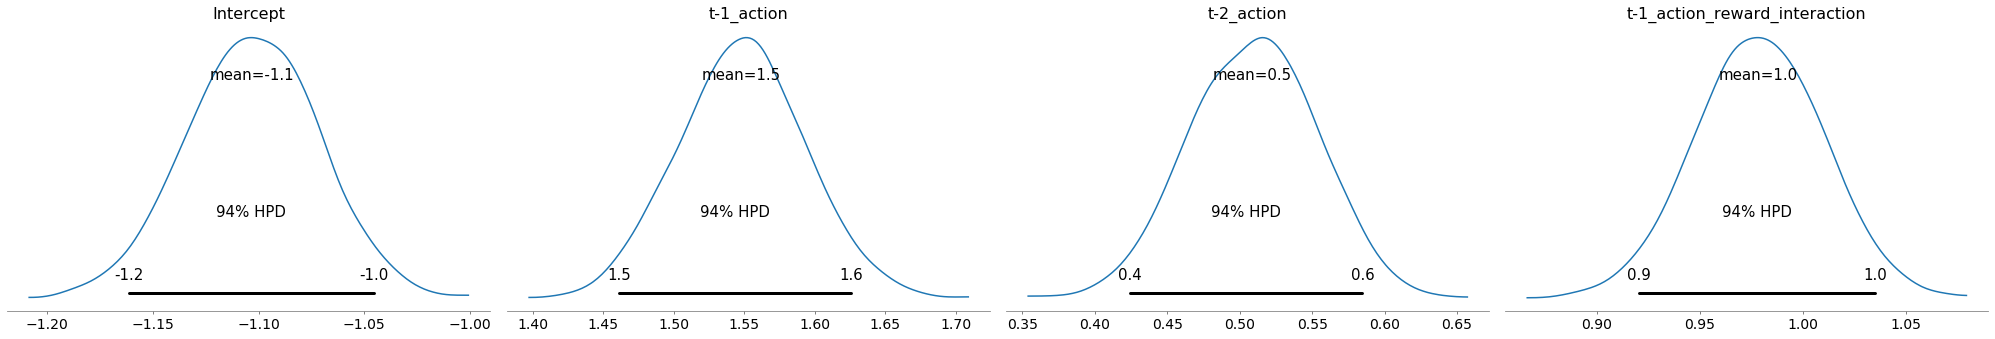

In [48]:
pm.plot_posterior(trace)